## Install packages

In [ ]:
!pip install quantimpy
!pip install pointpats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 32.1 MB/s eta 0:00:00


In [ ]:
from quantimpy import minkowski as mk
from quantimpy import morphology as mp
from __future__ import division, print_function
import numpy as np
try:
    from pylab import plt
except ImportError:
    print('Unable to import pylab. R_pca.plot_fit() will not work.')
from pointpats import PoissonPointProcess, PoissonClusterPointProcess, Window, poly_from_bbox, PointPattern
from pointpats import (
    distance_statistics,
    QStatistic,
    random,
    PointPattern,
)

## Data Set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
with open('drive/MyDrive/imgs_128_128.npy', 'rb') as f:
  dataset = np.load(f)
dataset = dataset*255

Mounted at /content/drive


## Robust PCA

In [ ]:
class R_pca:

    def __init__(self, D, mu=None, lmbda=None):
        self.D = D
        self.S = np.zeros(self.D.shape)
        self.Y = np.zeros(self.D.shape)

        if mu:
            self.mu = mu
        else:
            self.mu = np.prod(self.D.shape) / (4 * np.linalg.norm(self.D, ord=1))

        self.mu_inv = 1 / self.mu

        if lmbda:
            self.lmbda = lmbda
        else:
            self.lmbda = 2/11 #1 / np.sqrt(np.max(self.D.shape))

    @staticmethod
    def frobenius_norm(M):
        return np.linalg.norm(M, ord='fro')

    @staticmethod
    def shrink(M, tau):
        return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

    def svd_threshold(self, M, tau):
        U, S, V = np.linalg.svd(M, full_matrices=False)
        return np.dot(U, np.dot(np.diag(self.shrink(S, tau)), V))

    def fit(self, tol=None, max_iter=1000, iter_print=100):
        iter = 0
        err = np.Inf
        Sk = self.S
        Yk = self.Y
        Lk = np.zeros(self.D.shape)

        if tol:
            _tol = tol
        else:
            _tol = 1E-9 * self.frobenius_norm(self.D)

        #this loop implements the principal component pursuit (PCP) algorithm
        #located in the table on page 29 of https://arxiv.org/pdf/0912.3599.pdf
        while (err > _tol) and iter < max_iter:
            Lk = self.svd_threshold(
                self.D - Sk + self.mu_inv * Yk, self.mu_inv)                            #this line implements step 3
            Sk = self.shrink(
                self.D - Lk + (self.mu_inv * Yk), self.mu_inv * self.lmbda)             #this line implements step 4
            Yk = Yk + self.mu * (self.D - Lk - Sk)                                      #this line implements step 5
            err = self.frobenius_norm(self.D - Lk - Sk)
            iter += 1
            if (iter % iter_print) == 0 or iter == 1 or iter > max_iter or err <= _tol:
                pass#print('iteration: {0}, error: {1}'.format(iter, err))

        self.L = Lk
        self.S = Sk
        return Lk, Sk

    def plot_fit(self, size=None, tol=0.1, axis_on=True):

        n, d = self.D.shape

        if size:
            nrows, ncols = size
        else:
            sq = np.ceil(np.sqrt(n))
            nrows = int(sq)
            ncols = int(sq)

        ymin = np.nanmin(self.D)
        ymax = np.nanmax(self.D)
        print('ymin: {0}, ymax: {1}'.format(ymin, ymax))

        numplots = np.min([n, nrows * ncols])
        plt.figure()

        for n in range(numplots):
            plt.subplot(nrows, ncols, n + 1)
            plt.ylim((ymin - tol, ymax + tol))
            plt.plot(self.L[n, :] + self.S[n, :], 'r')
            plt.plot(self.L[n, :], 'b')
            if not axis_on:
                plt.axis('off')

## Anormaly detection

In [ ]:
def detection(image, visu = False):
    rpca = R_pca(image)
    L, S = rpca.fit(max_iter=10000, iter_print=100)
    seuil = np.percentile(S, 1)
    S[S>=seuil] = 0
    S[S<seuil] = 1
    S = S.astype(np.bool_)
    Sdil = mp.dilate(S,4)
    size = int(np.sum(S))
    coordinates = np.array(np.where(S))
    random_pattern = random.poisson(hull = np.array([0,0,128,128]), size=size)
    qstat = QStatistic(np.array(coordinates).T)
    print("P_value: ",qstat.chi2_pvalue)

    if visu == True :
        f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True, figsize=(25,4))
        ax1.imshow(image,'gray')
        ax1.set_title('Original')
        ax2.imshow(L,'gray')
        ax2.set_title('Low Rank')
        ax3.imshow(S,'gray')
        ax3.set_title('Sparse Matrix')
        ax4.imshow(Sdil,'gray')
        ax4.set_title('Dilate Matrix')
        ax5.scatter(
            *coordinates,
            color="k",
            marker=".",
            label="Sparse"
        )
        ax5.scatter(*random_pattern.T, color="r", marker="x", label="Random")
        ax5.legend(ncol=1, loc="center left")
        qstat.plot()
        plt.show()
    return qstat.chi2_pvalue

##Un exemple

Iceberg

P_value:  0.1805524365282424


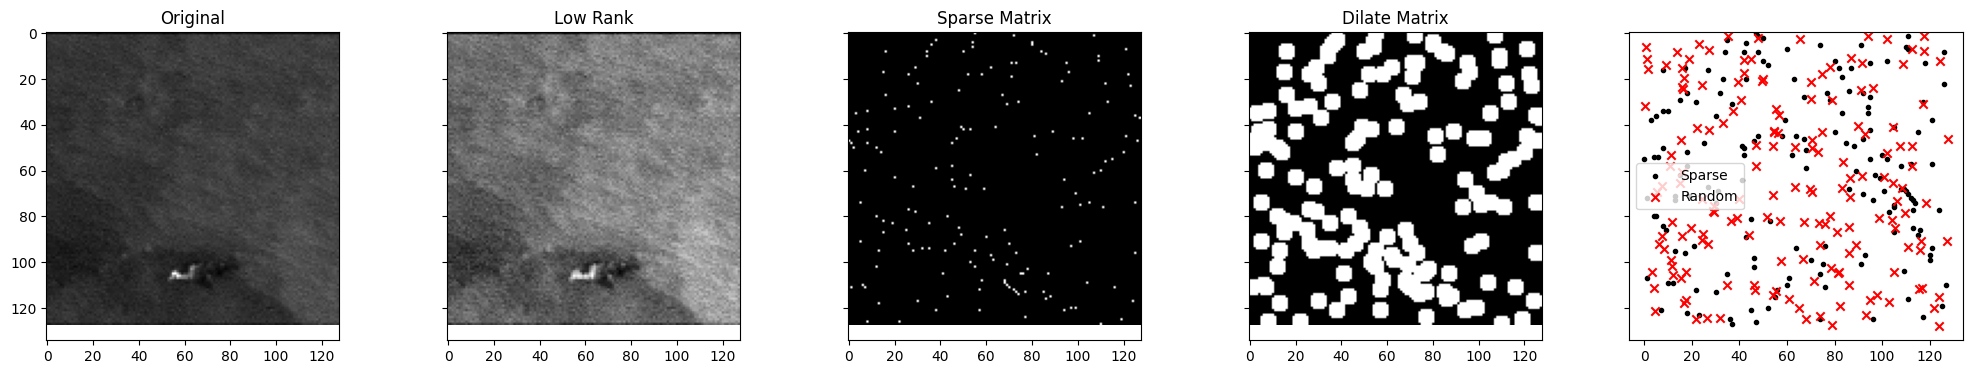

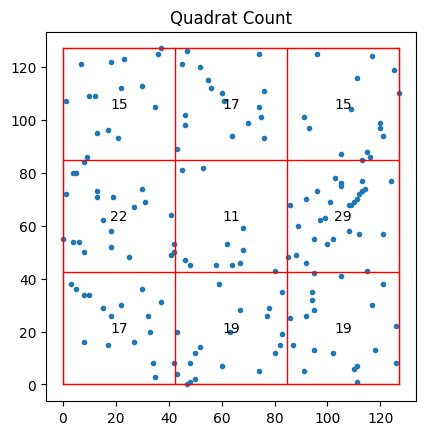

In [ ]:
detection(dataset[17000], visu=True)

biological spill

P_value:  0.0057185550890992915


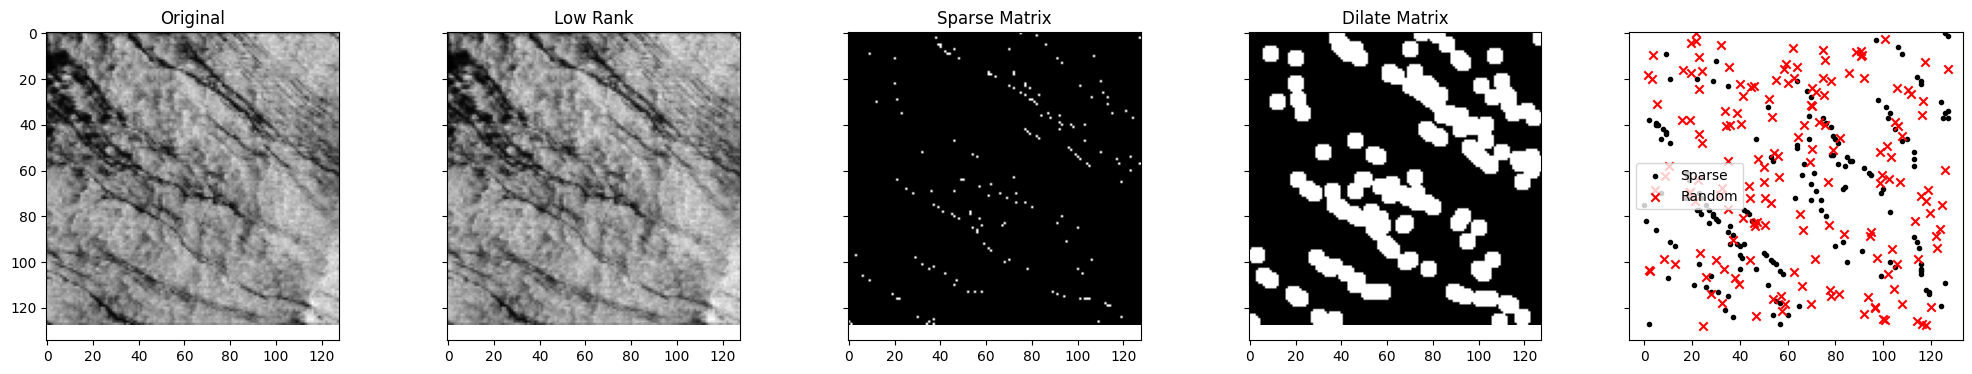

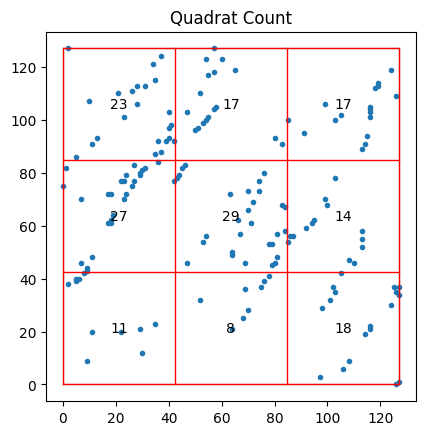

In [ ]:
detection(dataset[19999], visu=True)

Pur ocean

P_value:  0.49008822028284993


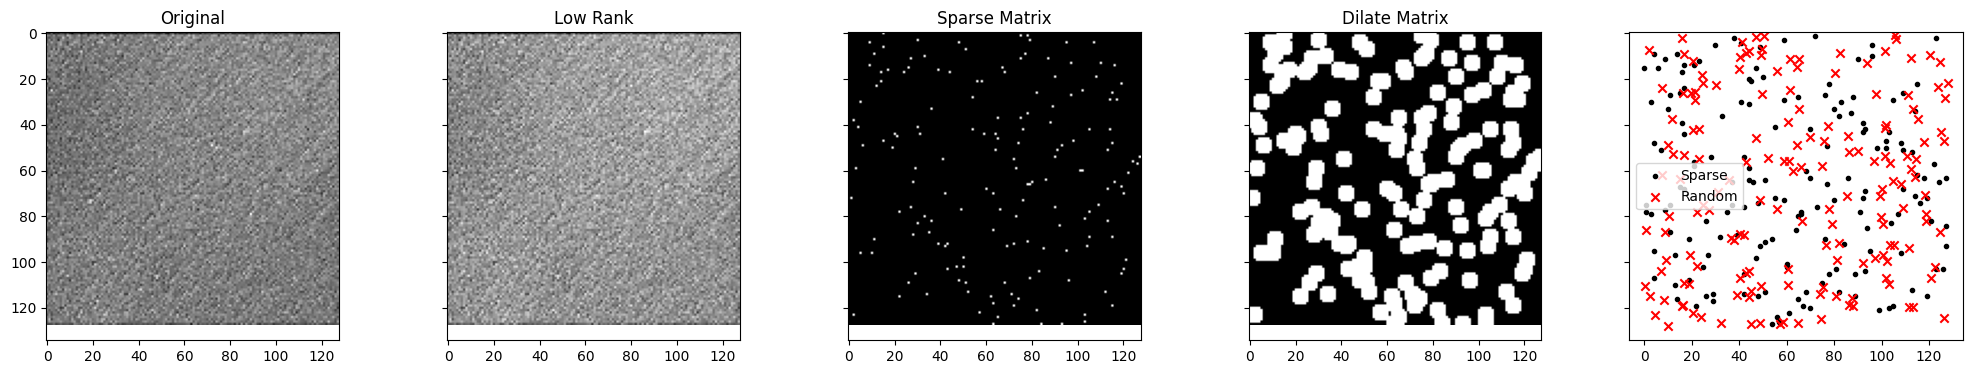

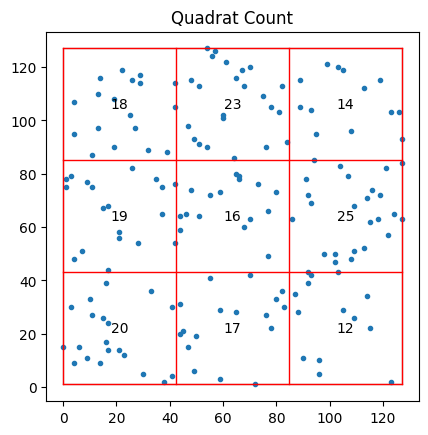

In [ ]:
detection(dataset[1], visu=True)

## Unsupervised Anormaly Detection (Biological spill VS Pur Ocean)  

Qstatistic

P_value:  0.2308990668316938
P_value:  0.49008822028284993
P_value:  0.2044785192662889
P_value:  0.3828821344510285
P_value:  0.056817123461364985
P_value:  0.5015592188464791
P_value:  0.4900882202828498
P_value:  0.1396287615351875
P_value:  0.12646693212670343
P_value:  0.5248385155895801
P_value:  0.3443576710822222
P_value:  0.23089906683169387
P_value:  0.056817123461364985
P_value:  0.7312177684978545
P_value:  0.8226991662303114
P_value:  0.3632873360449115
P_value:  0.23790788225973375
P_value:  0.8914874652748964
P_value:  0.1922117092723696
P_value:  0.1922117092723696
P_value:  0.11059700917885534
P_value:  0.8538075967853809
P_value:  0.04397827233012286
P_value:  0.8436844335007774
P_value:  0.9617309457103776
P_value:  0.12646693212670357
P_value:  0.11830045585313341
P_value:  0.09649954158420163
P_value:  0.8732390140334282
P_value:  0.7549661163744177
P_value:  0.0057185550890992915
P_value:  0.08699511376484115
P_value:  0.0008874231552096348
P_value:  0.00293865911

(array([32.,  9.,  4.,  3.,  0.,  4.,  0.,  2.,  3.,  3.]),
 array([5.01348758e-39, 9.61730946e-02, 1.92346189e-01, 2.88519284e-01,
        3.84692378e-01, 4.80865473e-01, 5.77038567e-01, 6.73211662e-01,
        7.69384757e-01, 8.65557851e-01, 9.61730946e-01]),
 <BarContainer object of 10 artists>)

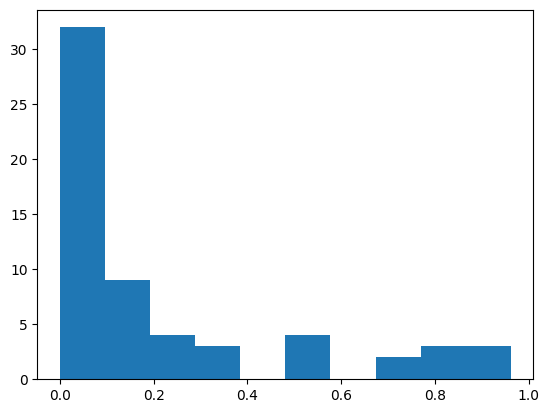

In [ ]:
l = []

for i in range(30):
  l.append(detection(dataset[i], visu=False))

for i in range(19999,19999+30):
  l.append(detection(dataset[i], visu=False))

plt.hist(l)

(array([8., 4., 3., 3., 3., 1., 0., 2., 3., 3.]),
 array([0.04397827, 0.13575354, 0.22752881, 0.31930407, 0.41107934,
        0.50285461, 0.59462988, 0.68640514, 0.77818041, 0.86995568,
        0.96173095]),
 <BarContainer object of 10 artists>)

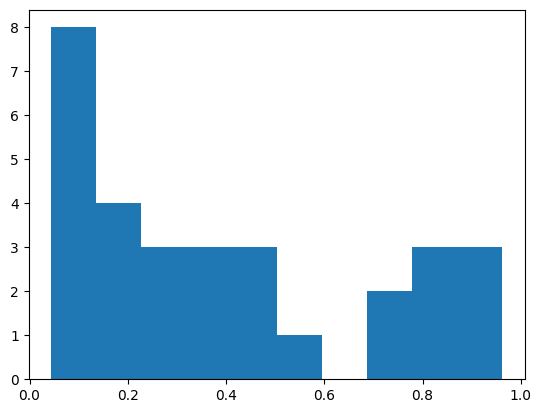

In [ ]:
plt.hist(l[0:30])

(array([26.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([5.01348758e-39, 1.64164128e-02, 3.28328256e-02, 4.92492384e-02,
        6.56656512e-02, 8.20820640e-02, 9.84984767e-02, 1.14914890e-01,
        1.31331302e-01, 1.47747715e-01, 1.64164128e-01]),
 <BarContainer object of 10 artists>)

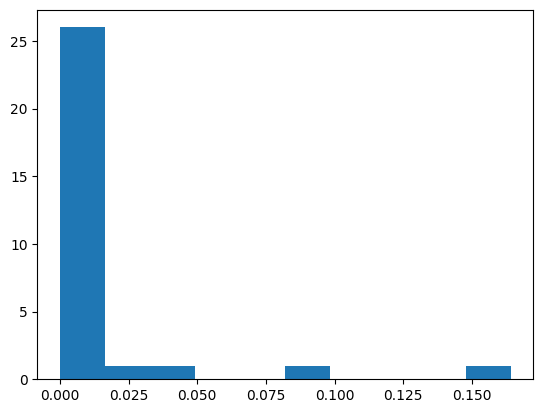

In [ ]:
plt.hist(l[30:60])

minkovski

In [ ]:
MM = []
MM2 = []

for i in range(20):
  rpca = R_pca(dataset[i])
  L, S = rpca.fit(max_iter=10000, iter_print=100)
  seuil = np.percentile(S, 1)
  S[S>=seuil] = 0
  S[S<seuil] = 1
  S = S.astype(np.bool_)
  Sdil = mp.dilate(S,4)
  sparse = mk.functionals(Sdil)
  MM.append(sparse)

for i in range(19999, 19999+20):
  rpca = R_pca(dataset[i])
  L, S = rpca.fit(max_iter=10000, iter_print=100)
  seuil = np.percentile(S, 1)
  S[S>=seuil] = 0
  S[S<seuil] = 1
  S = S.astype(np.bool_)
  Sdil = mp.dilate(S,4)
  sparse = mk.functionals(Sdil)
  MM2.append(sparse)

MM = np.array(MM) * np.array([1, 2*np.pi, np.pi])
MM2 = np.array(MM2) * np.array([1, 2*np.pi, np.pi])

In [ ]:
f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, sharey=True, figsize=(20, 5))
ax1.hist(MM[:,0])
ax1.set_title('M0')
ax2.hist(MM[:,1])
ax2.set_title('M1')
ax3.hist(MM[:,2])
ax3.set_title('M2')
ax4.hist(MM2[:,0])
ax4.set_title('M0')
ax5.hist(MM2[:,1])
ax5.set_title('M1')
ax6.hist(MM2[:,2])
ax6.set_title('M2')

Text(0.5, 1.0, 'biological spill')

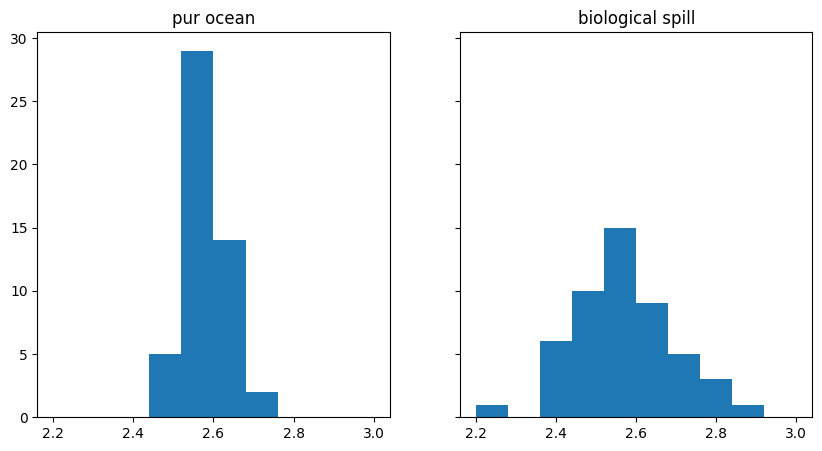

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax1.hist(MM[:,0]/MM[:,1], range=[2.2,3])
ax1.set_title('pur ocean')
ax2.hist(MM2[:,0]/MM[:,1], range=[2.2,3])
ax2.set_title('biological spill')

##Fourier

In [ ]:
def ft(img, r):
  # Apply 2D Fourier Transform
  f_transform = np.fft.fft2(img)
  f_transform_shifted = np.fft.fftshift(f_transform)

  # Create a mask (high-pass filter)
  rows, cols = img.shape
  crow, ccol = rows // 2, cols // 2
  mask = np.ones((rows, cols), np.uint8)
  center = [crow, ccol]
  x, y = np.ogrid[:rows, :cols]
  mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
  mask[mask_area] = 0

  # Apply the high-pass filter to the Fourier Transform
  f_transform_filtered = f_transform_shifted * mask

  # Inverse Fourier Transform
  img_filtered = np.fft.ifft2(np.fft.ifftshift(f_transform_filtered)).real
  img_filtered = np.uint8(img_filtered)
  return img_filtered


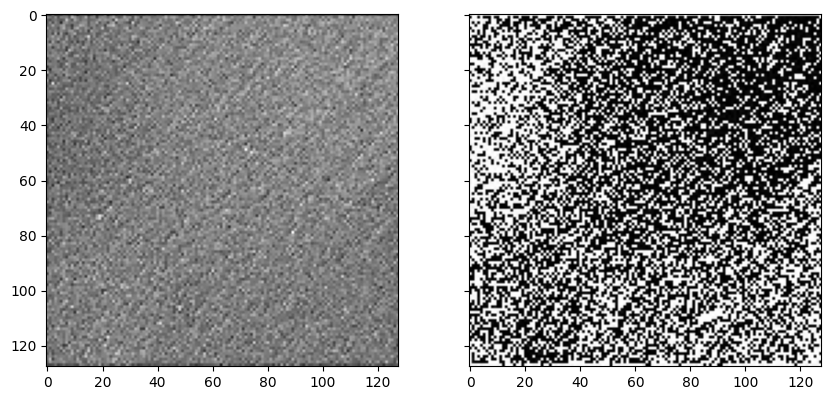

In [ ]:
img_filtered = ft(dataset[1],0.00001)
f, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax1.imshow(dataset[1],"gray")
ax2.imshow(img_filtered,"gray")

Fourier SCIPY

In [ ]:
from scipy import fftpack

In [ ]:
def pruned_fourier(im, fraction=0.5, d=1):
  im_fft = fftpack.fft2(im)

# Call ff a copy of the original transform. Numpy arrays have a copy
# method for this purpose.
  im_fft2 = im_fft.copy()

# Set r and c to be the number of rows and columns of the array.
  r, c = im_fft2.shape

  sample_freq = fftpack.fftfreq(r, d=d)

  seuil= int(np.ceil((r-1)*(fraction)))

  limit = sample_freq[seuil]

  im_fft2[sample_freq > limit] = 0

  im_fft2[-sample_freq < limit] = 0

  filtered_sig = fftpack.ifft2(im_fft2).real

  return filtered_sig




13.0

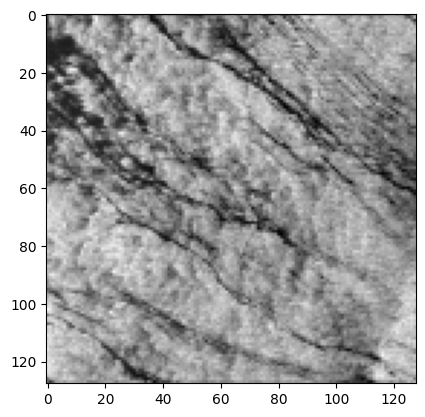

In [ ]:
im=dataset[19999]

fouried = pruned_fourier(im=im, fraction=1)
plt.imshow(fouried, "gray")



(array([13., 12., 14., 12., 12., 14., 12., 14., 12., 13.]),
 array([0.        , 0.00039063, 0.00078125, 0.00117188, 0.0015625 ,
        0.00195312, 0.00234375, 0.00273438, 0.003125  , 0.00351563,
        0.00390625]),
 <BarContainer object of 10 artists>)

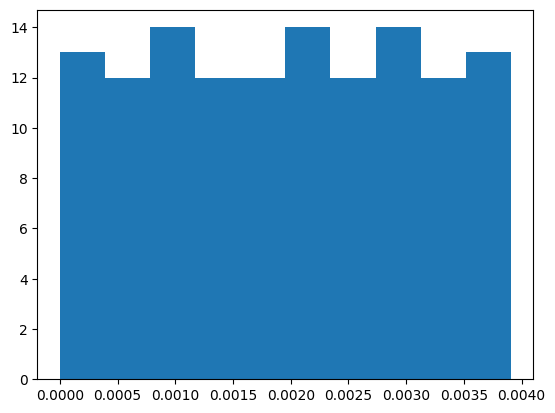

In [ ]:
plt.hist(np.abs(fftpack.fftfreq(128, d=128)))

Text(0.5, 1.0, 'Fourier transform')

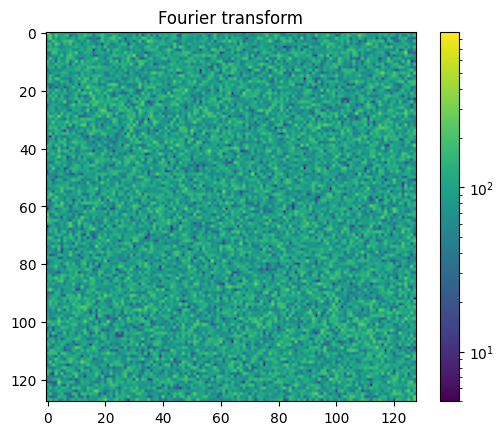

In [ ]:
im_fft = fftpack.fft2(im)

# Show the results

def plot_spectrum(im_fft):
    from matplotlib.colors import LogNorm
    # A logarithmic colormap
    plt.imshow(np.abs(im_fft), norm=LogNorm(vmin=5))
    plt.colorbar()

plt.figure()
plot_spectrum(im_fft)
plt.title('Fourier transform')

plt.figure()
plot_spectrum(im_fft2)
plt.title('Filtered Spectrum')

Text(0.5, 1.0, 'Filtered Spectrum')

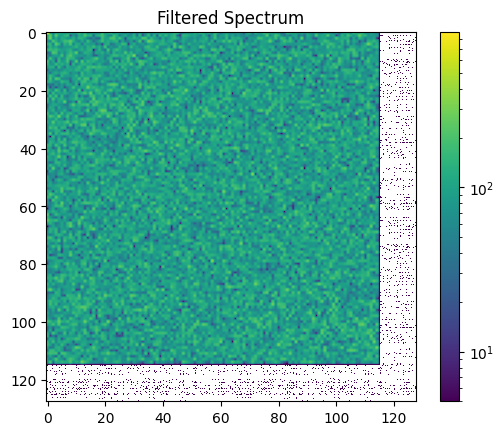

In [ ]:
# In the lines following, we'll make a copy of the original spectrum and
# truncate coefficients.

# Define the fraction of coefficients (in each direction) we keep
keep_fraction = 0.9

# Call ff a copy of the original transform. Numpy arrays have a copy
# method for this purpose.
im_fft2 = im_fft.copy()

# Set r and c to be the number of rows and columns of the array.
r, c = im_fft2.shape

# Set to zero all rows with indices between r*keep_fraction and
# r*(1-keep_fraction):
im_fft2[int(r*keep_fraction):r] = 0

# Similarly with the columns:
im_fft2[:, int(c*keep_fraction) : c] = 0

plt.figure()
plot_spectrum(im_fft2)
plt.title('Filtered Spectrum')

Text(0.5, 1.0, 'Reconstructed Image')

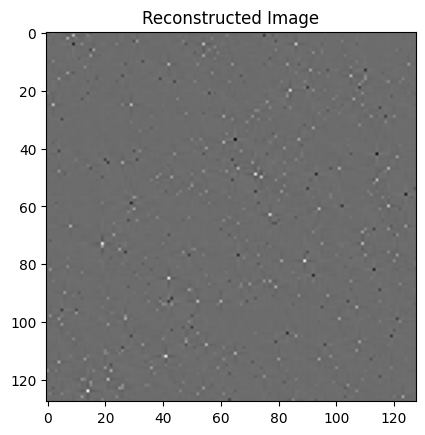

In [ ]:
# Reconstruct the denoised image from the filtered spectrum, keep only the
# real part for display.
im_new = fftpack.ifft2(im_fft2).real

plt.figure()
plt.imshow(im_new,"gray")
plt.title('Reconstructed Image')

In [ ]:
rpca = R_pca(im_new)
L, S = rpca.fit(max_iter=10000, iter_print=100)

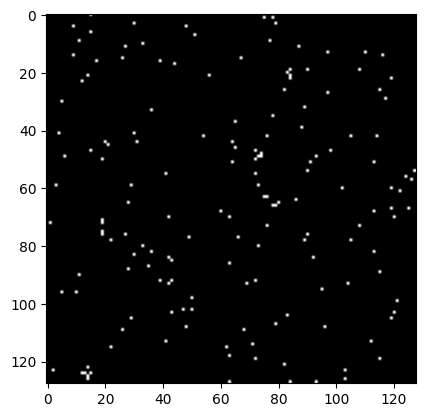

In [ ]:
plt.imshow(S, "gray")

Text(0.5, 1.0, 'Dilate Matrix')

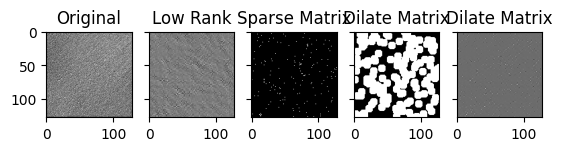

In [ ]:
seuil = np.percentile(S, 1)
S[S>=seuil] = 0
S[S<seuil] = 1
S = S.astype(np.bool_)
Sdil = mp.dilate(S,6)
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True)
ax1.imshow(dataset[1],'gray')
ax1.set_title('Original')
ax2.imshow(L,'gray')
ax2.set_title('Low Rank')
ax3.imshow(S,'gray')
ax3.set_title('Sparse Matrix')
ax4.imshow(Sdil,'gray')
ax4.set_title('Dilate Matrix')
ax5.imshow(im_new,'gray')
ax5.set_title('Dilate Matrix')

In [ ]:
mk.functionals(Sdil)

(9511.0, 295.5413767532032, 1.8302818455567966)

Text(0.5, 1.0, 'Dilate Matrix')

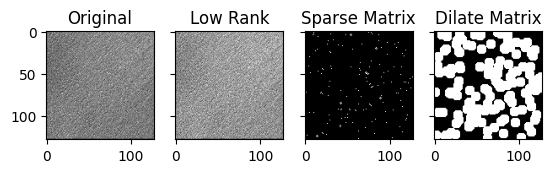

In [ ]:
S=im_new
seuil = np.percentile(S, 1)
S[S>=seuil] = 0
S[S<seuil] = 1
S = S.astype(np.bool_)
Sdil = mp.dilate(S,6)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
ax1.imshow(dataset[1],'gray')
ax1.set_title('Original')
ax2.imshow(L,'gray')
ax2.set_title('Low Rank')
ax3.imshow(S,'gray')
ax3.set_title('Sparse Matrix')
ax4.imshow(Sdil,'gray')
ax4.set_title('Dilate Matrix')

In [ ]:
mk.functionals(Sdil)

(8087.0, 215.1321689575262, 0.6366197723675814)